# Prediction of employee attrition with AI

Employees leaving companies involve costs associated with separation, temporary loss of productivity, recruitment and interviewing candidates as well as training and onboarding of new employees. Overall, losing an employee is a matter of money, time and reduces team cohesion. 

<img src="./images/img_1.png" width="600" height="300" align="center"/>

Therefore, it would be highly valuable to predict the following key questions:

* <span style='color:teal'> **Will an employee leave?**  </span>
* <span style='color:teal'> **How many years will an employee stay?**  </span>

Furthermore, it is essential for an effective planning and risk assessment to analyse the key points: 
* <span style='color:teal'> **Why would an employee leave?**  </span>
* <span style='color:teal'> **What are the risk factors to keep track of?**  </span>

The objective of this project is to find answers to these questions by analysing employee data and AI models.

<img src="./images/img_2.png" width="600" height="375" align="center"/>

## Table of Contents

* [1. Data exploration](#chapter1)
    * [1.1. Preliminary data overview](#section_1_1)
    * [1.2. Data visualization](#section_1_2)
        * [1.2.1. Target variables: attrition and years at the company](#section_1_2_1)
        * [1.2.2. Employees' features](#section_1_2_2)
        * [1.2.3. Employees' features influence on attrition](#section_1_2_3)
        * [1.2.4. Employees' features influence on the total number of years at the company](#section_1_2_4)
        * [1.2.5. Employees' features correlation](#section_1_2_5)
* [2. AI models](#chapter2) 
    * [2.1. Data pre-processing](#section_2_1)
        * [2.1.1. Preliminary data overview](#section_2_1_1)
        * [2.1.2. Data types and invalid values](#section_2_1_2)
    * [2.2. Classification models - Predicting employee attrition](#section_2_2)
        * [2.2.1. K-Neighbors](#section_2_2_1)
        * [2.2.2. Decision Tree](#section_2_2_2)
        * [2.2.3. Random Forest](#section_2_2_3)
        * [2.2.4. Logistic Regression](#section_2_2_4)
        * [2.2.5. Neural Network](#section_2_2_5)
    * [2.3. Regression models - Predicting number of years in the company](#section_2_3)
        * [2.3.1. Ridge Regression](#section_2_3_1)
        * [2.3.2. Neural Network](#section_2_3_2)      
* [3. Conclusion](#chapter3) 

# 1. Data exploration  <a class="anchor" id="section_1"></a>

## 1.1. Preliminary data overview  <a class="anchor" id="section_1_1"></a>

Let's first load the necessary packages:

In [5]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.model_selection import validation_curve, learning_curve, train_test_split, RepeatedStratifiedKFold

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error
from sklearn.utils import class_weight


from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization

We now fetch the available employee data:

In [6]:
data_path = os.getcwd()

data_file_train = 'WA_Fn-UseC_-HR-Employee-Attrition.csv'

data = pd.read_csv(data_path + '/' + data_file_train)

Let's first check if there are any missing values:

In [7]:
# Function to check missing data

def check_missing(dataset):

    num_missing_percol = dataset.isnull().sum().sort_values(ascending=False)

    col_with_missing = num_missing_percol[num_missing_percol > 0]
    percentage = col_with_missing/dataset[col_with_missing.index].shape[0]

    df_missing = pd.concat([col_with_missing, round(
        percentage*100, 1)], keys=['Missing Values', 'Percentage %'], axis=1)

    return df_missing

In [8]:
df_missing = check_missing(data)
df_missing

,Missing Values,Percentage %


In [9]:
missing = df_missing['Missing Values'].sum()
print(f'There are a total of {missing} missing values')
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

There are a total of 0 missing values


Great! There are no missing values. 

We now split our data into two sets, one for training and the other one for testing. The former set will be used for feature analysis and consequent training of the prediction models. The test set however, will be used only for further evaluation of the models. This essential in order to assess whether the model is able to make accurate predictions on unseen data which has not been used for developing the models' internal parameters. It should be kept in mind that, our objective is to achieve a suitable **variance and bias trade-off**. On the one hand, a model with high bias and low variance is not able to effectively capture the underlying patterns of the training data with an oversimplified approach, leading to high error on training and test data. In this case, **underfitting** takes place. On the other hand, a model with high variable and low bias performs well on our training data but provides poor results when applied to new data. This happens because the model captures the noise along with the underlying patterns of the training data and consequently is not able to generalise to unseen data. This is known as **overfitting**. Therefore, properly capturing our data patterns and relationships as well as preventing from noise capturing is the main objective to achieve realiable predictions.

We now set the training set to represent 80 % of the initial data and the testing set to be the remaining 20 %. Furthermore, we take into account the to target variable, that is, the feature we are aiming to predict, so that we have the same distribution of attrition values in both sets.  

In [10]:
data, data_test, y_att, y_att_test = train_test_split(
    data, data['Attrition'], stratify=data['Attrition'], train_size=0.8, test_size=0.2, random_state=123)

Let's now make a quick overview of our features' type and unique values:

In [11]:
df_type_num = pd.DataFrame(data=zip(data.dtypes, data.nunique()), columns=[
                           'Type', 'Unique'], index=data.columns)
df_type_num

,Type,Unique
Age,int64,43
Attrition,object,2
BusinessTravel,object,3
DailyRate,int64,775
Department,object,3
DistanceFromHome,int64,29
Education,int64,5
EducationField,object,6
EmployeeCount,int64,1
EmployeeNumber,int64,1176


Let's now convert our target variable of attrition to binary values, that is, assign value of '1' for positive attrition and '0' for negative attrition:

In [12]:
y_att_str = y_att.copy()

if type(y_att[0]) == str:

    dict_binary = {'Yes': 1, 'No': 0}

    y_att = pd.Series(
        list(map(lambda x: dict_binary[x], y_att)), name=y_att.name, index=y_att.index)
    y_att_test = pd.Series(list(map(
        lambda x: dict_binary[x], y_att_test)), name=y_att_test.name, index=y_att_test.index)

Let's also define a function to classify our features into numerical or categorical:

In [13]:
def num_cat_cols(dataset):
    num_cols = dataset.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = dataset.select_dtypes(include=['object', 'category']).columns

    return (num_cols, cat_cols)

It is important that we have a proper understanding of our data types what they represent. Our data mainly consists of continous numerical features and categorical features. Sometimes, we might have categorical features represented by numerical values. However, this does not mean they are continuous data, as each number would represent an individual category. Taking this into account, we are going to define as categorical data those features which have less than 6 unique values, that is, they only contain less than six possible values. 

Let's first check which features would be categorical according to our definition:

In [14]:
cat = df_type_num[df_type_num['Unique'] < 6]
cat

,Type,Unique
Attrition,object,2
BusinessTravel,object,3
Department,object,3
Education,int64,5
EmployeeCount,int64,1
EnvironmentSatisfaction,int64,4
Gender,object,2
JobInvolvement,int64,4
JobLevel,int64,5
JobSatisfaction,int64,4


Indeed, we can see that we have features such as the job level or performance rating which are considered numerical but they represent in fact categories. Therefore, we are now going to convert their type to object. 

Furthermore, we have identified some features which actually only consist of one unique value. It is the case of 'Over18' for example, which means that all the employees are over 18 years old. Therefore, these attributes are not going to provide any useful information so we can neglect them:

In [15]:
cat_ft = list(cat.index)
data[cat_ft] = data[cat_ft].astype('object')
data_test[cat_ft] = data_test[cat_ft].astype('object')

ft_to_remove = df_type_num[df_type_num['Unique'] == 1].index
data.drop(ft_to_remove, axis=1, inplace=True)
data_test.drop(ft_to_remove, axis=1, inplace=True)

The next step is to independently save our target variables from our data. Therefore, we set our targets to be attrition and the number of years at the company:

In [16]:
targets = ['Attrition', 'YearsAtCompany']
df_targets = data.copy()

y_years = data['YearsAtCompany']
y_years_test = data_test['YearsAtCompany']

data.drop(targets, axis=1, inplace=True)
data_test.drop(targets, axis=1, inplace=True)

We now check the number of employee features we are going to work with to develop our predictions:

In [17]:
print(f'There are {data.shape[0]} workers with {data.shape[1]} features')

There are 1176 workers with 30 features


## 1.2. Data Visualization  <a class="anchor" id="section_1_2"></a>

### 1.2.1. Target variables: attrition and years at the company  <a class="anchor" id="section_1_2_1"></a>

Visualizing our data allows us to better understand the problem and how to approach it. Let's first take a look at the ditribution of one of our target variables, the number of years at the company:

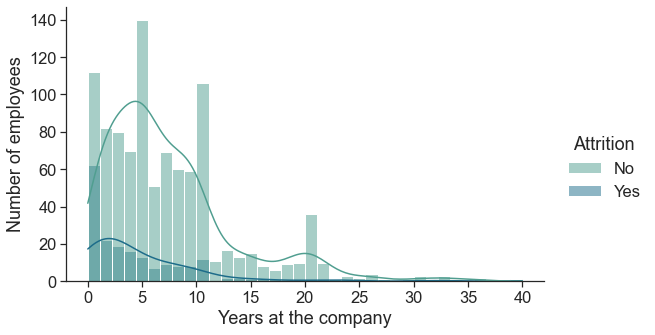

In [18]:
sns.set_theme(font_scale=1.5, style="ticks")
height = 5; golden_ratio = 1.618
g = sns.displot(df_targets, x='YearsAtCompany', hue='Attrition', kde=True,
                height=height, aspect=golden_ratio, palette=sns.color_palette('crest', n_colors=2))
g.set(xlabel='Years at the company', ylabel='Number of employees')


We can observe that the data mainly consists of employees who have been in the company less than 10 years. This normal since the record of employees in a company 

Let's now look at the attrition:

Text(0.5, 1.0, 'Left the company?')

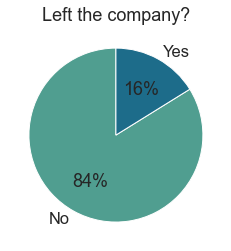

In [19]:
labels = [lb for lb in df_targets['Attrition'].value_counts().index]
colors = sns.color_palette(
    'crest', n_colors=2)[0:2]
plt.pie(df_targets['Attrition'].value_counts(), labels=labels, startangle=90,
        autopct='%1.0f%%', colors=colors)

plt.gca().set_title('Left the company?', fontsize='18')

We can see that 84% of the employees have not left the company whereas 16% did left. It is important to acknowledge the fact that there is not an even distribution of these two classes. The reason for this is that, when training our prediction models, 

### 1.2.2. Employees' features <a class="anchor" id="section_1_2_2"></a>

Let's dive into the rest of our employees' features. We are firsly going to assign more descriptive labels to our features' values for a better understanding. For example, 'Education' field can be represented by 5 unique values from 1 to 5 for each employee. However, these values represent levels of education so that category '1' corresponds to 'Below college' education whereas category '5' corresponds to 'Doctor'. For visualization purporses, we will substitute these numerical categories by informative features.

In [20]:
fts_cat = {'Education': {'1': 'Below College', '2':'College', '3': 'Bachelor', '4': 'Master', '5': 'Doctor'}, 
        'EnvironmentSatisfaction': {'1': 'Low', '2': 'Medium', '3':'High', '4': 'Very High'}, 
        'JobInvolvement': {'1': 'Low', '2': 'Medium', '3':'High', '4': 'Very High'}, 
        'JobSatisfaction': {'1': 'Low', '2': 'Medium', '3':'High', '4': 'Very High'}, 
        'PerformanceRating': {'1': 'Low', '2': 'Good', '3':'Excelent', '4': 'Outstanding'}, 
        'RelationshipSatisfaction': {'1': 'Low', '2': 'Medium', '3':'High', '4': 'Very High'}, 
        'WorkLifeBalance': {'1':'Bad', '2': 'Good', '3': 'Better', '4': 'Best'}}

In [21]:
data_train_lb = data.copy()

for ft in fts_cat.keys():
    values = data_train_lb[ft].unique()
    for val in values:
        data_train_lb.loc[data_train_lb[ft] == val, ft] = fts_cat[ft][f'{int(float(val))}']

Let's take a look now into our categorical features:

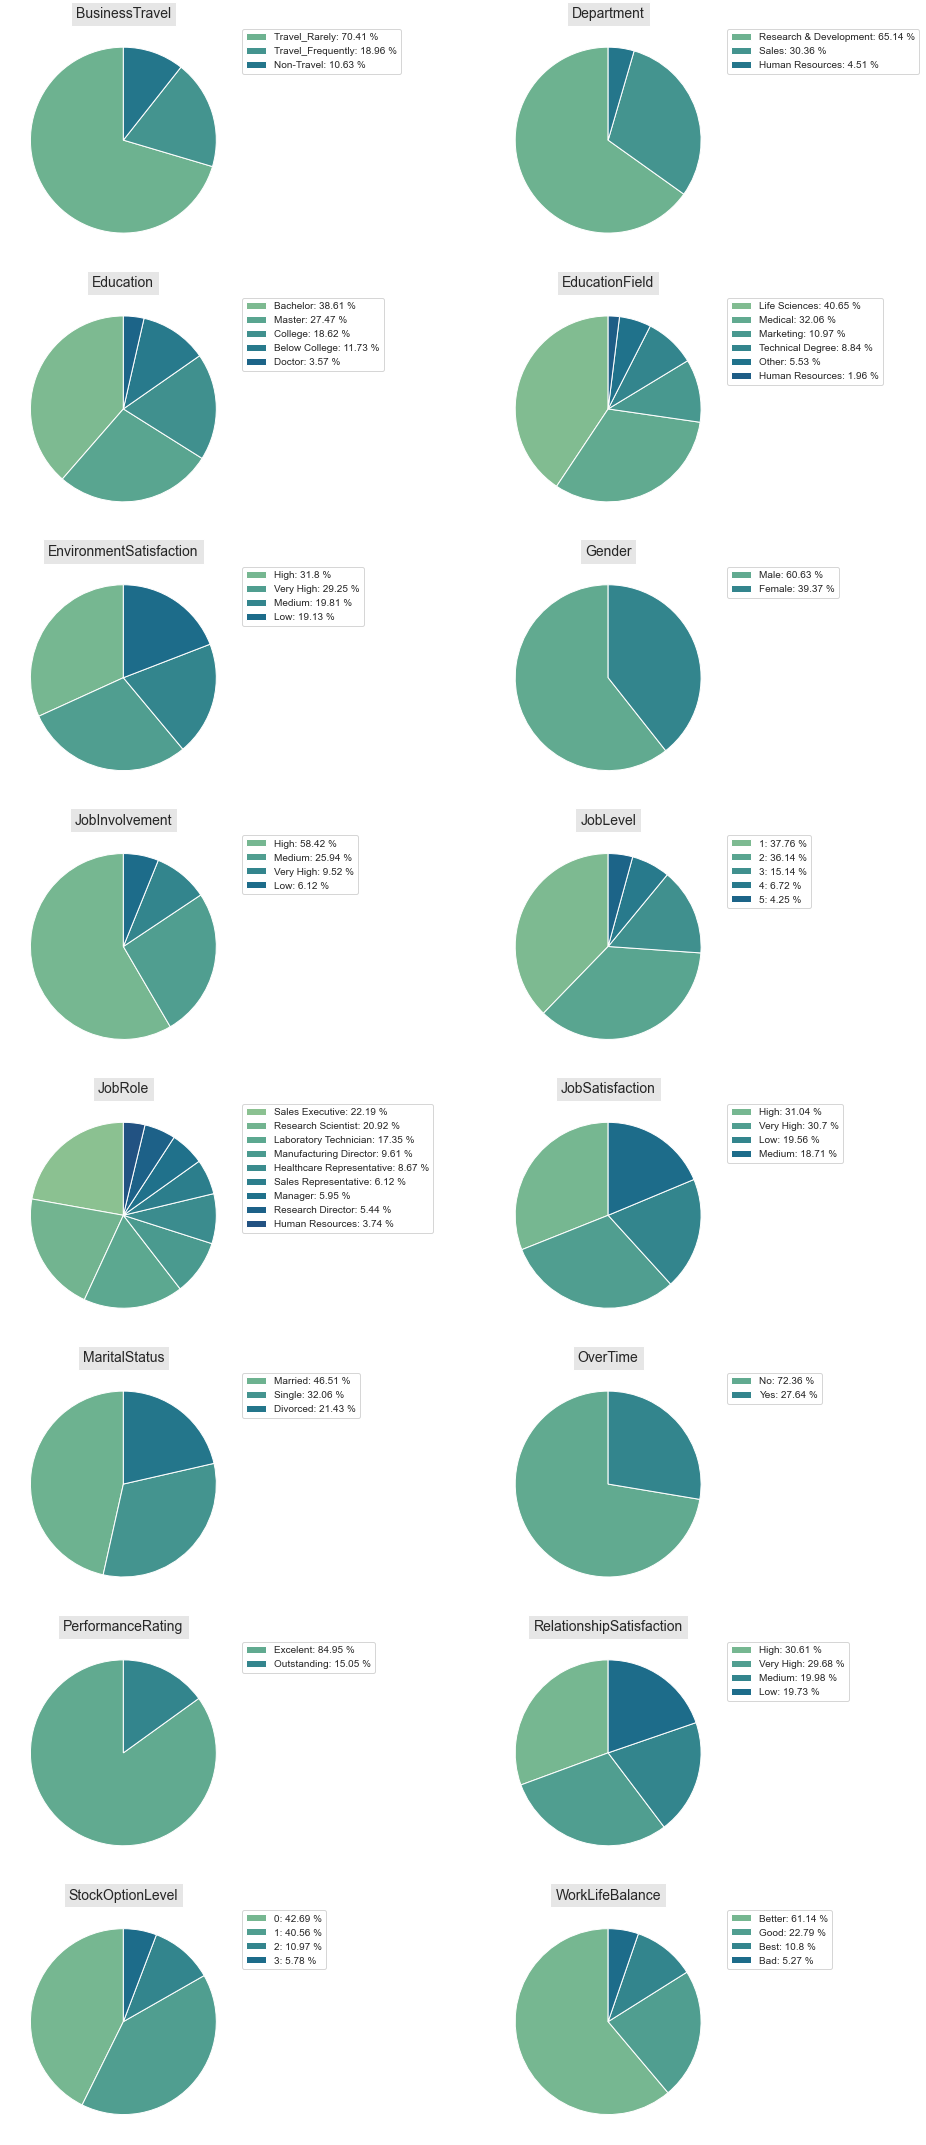

In [22]:
num_ft, cat_ft = num_cat_cols(data_train_lb)
num = len(cat_ft)

fig = plt.figure(figsize=(15, 60))

for i, ft in enumerate(cat_ft):

    counts = data_train_lb[ft].value_counts()
    colors = sns.color_palette(
        'crest', n_colors=len(counts)+1)[0:len(counts)]
    labels = list(counts.index)

    plt.subplot(num, 2, i+1)
    plt.pie(counts, colors=colors, startangle=90)

    plt.gca().set_title(ft, fontsize='14', bbox={'facecolor': '0.9', 'pad': 5})

    labels_box = [
        f'{label}: {round(c*100/data.shape[0],2)} %' for label, c in zip(labels, counts)]
    plt.gca().legend(labels_box, loc='best', bbox_to_anchor=(0.99, 1.0), fontsize=10)

    i += 1

plt.tight_layout()


* <span style='color:teal'> Business travel:  </span> the majority of the employees rarely travel (70%).\
` `  
` ` 
* <span style='color:teal'> Department:  </span> 65% of the employees belong to the R&D deparment, followed by Sales (30%) and HR (4%).\
` `  
` `
* <span style='color:teal'> Education:  </span> most employeed have a bachelor's degree (nearly 40%) followed my master's degree (27%) and only 3% have a doctoral degree.\
` `  
` `
* <span style='color:teal'> Education field  </span> Most employees have background in life sciences (40%) and medical (32%).\
` `  
` `
* <span style='color:teal'> Environment satisfaction:  </span> nearly 60% have a high or very high environment satisfaction and 20% have a low satisfaction.\
` `  
` `
* <span style='color:teal'> Gender:  </span> there are more men (60%) than women (40%).\
` `  
` `
* <span style='color:teal'> Job involvement: </span> nearly 60% of employees have a high job involvement and only 6% have a low involvement.\
` `  
` `
* <span style='color:teal'> Job level:  </span> most of the employees are involved in low job levels (nearly 70% in the first two levels), whereas only 10% are involved in the two highest levels.\
` `  
` `
* <span style='color:teal'> Job role: </span> The three most common roles are sales executive (22%), research scientist(20%) and laboratory technician (17%).\
` `  
` `
* <span style='color:teal'> Job satisfaction:  </span>nearly 60% have high or very high satisfaction whereas 40% have medium or low satisfaction.\
` `  
` `
* <span style='color:teal'> Marital status: </span> 47% of the employees are married whereas 53% are single or divorced.\
` `  
` `
* <span style='color:teal'> Overtime:  </span>the majority of employees do not work overtime (72%).\
` `  
` `
* <span style='color:teal'> Performance rating: </span> 85% of the employees have excellent performance and 15% have outstanding performance.\
` `  
` `
* <span style='color:teal'> Relationship satisfaction: </span>nearly 60% have a high or very high relationship satisfaction and 20% have a low satisfaction.\
` `  
` `
* <span style='color:teal'> Stock option level: </span> stock options 0 and 1 represent nearly 80% of the data.\
` `  
` `
* <span style='color:teal'> Work-life balance: </span> 60% of the employees have a better work-life balance, followed by good (23%), best (10%) and bad (5%).

We now take a look at out numerical data:

In [23]:
data.describe()

,Age,DailyRate,DistanceFromHome,EmployeeNumber,HourlyRate,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000
mean,36.815476,815.522959,9.243197,1027.970238,65.605442,6391.375000,14417.109694,2.683673,15.242347,11.205782,2.793367,4.240646,2.170068,4.107143
std,9.035578,403.827175,8.154281,607.273191,20.364026,4604.568871,7111.438369,2.508594,3.640427,7.672898,1.290485,3.645913,3.215651,3.555816
min,18.000000,102.000000,1.000000,1.000000,30.000000,1009.000000,2094.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,481.000000,2.000000,475.750000,48.000000,2907.750000,8249.500000,1.000000,12.000000,6.000000,2.000000,2.000000,0.000000,2.000000
50%,36.000000,811.000000,7.000000,1035.500000,65.000000,4899.000000,14624.000000,2.000000,14.000000,10.000000,3.000000,3.000000,1.000000,3.000000
75%,43.000000,1172.500000,14.000000,1568.250000,83.000000,8107.250000,20630.250000,4.000000,18.000000,15.000000,3.000000,7.000000,2.000000,7.000000
max,60.000000,1499.000000,29.000000,2068.000000,100.000000,19999.000000,26999.000000,9.000000,25.000000,40.000000,6.000000,18.000000,15.000000,17.000000


Now let's look at the rest of variables:

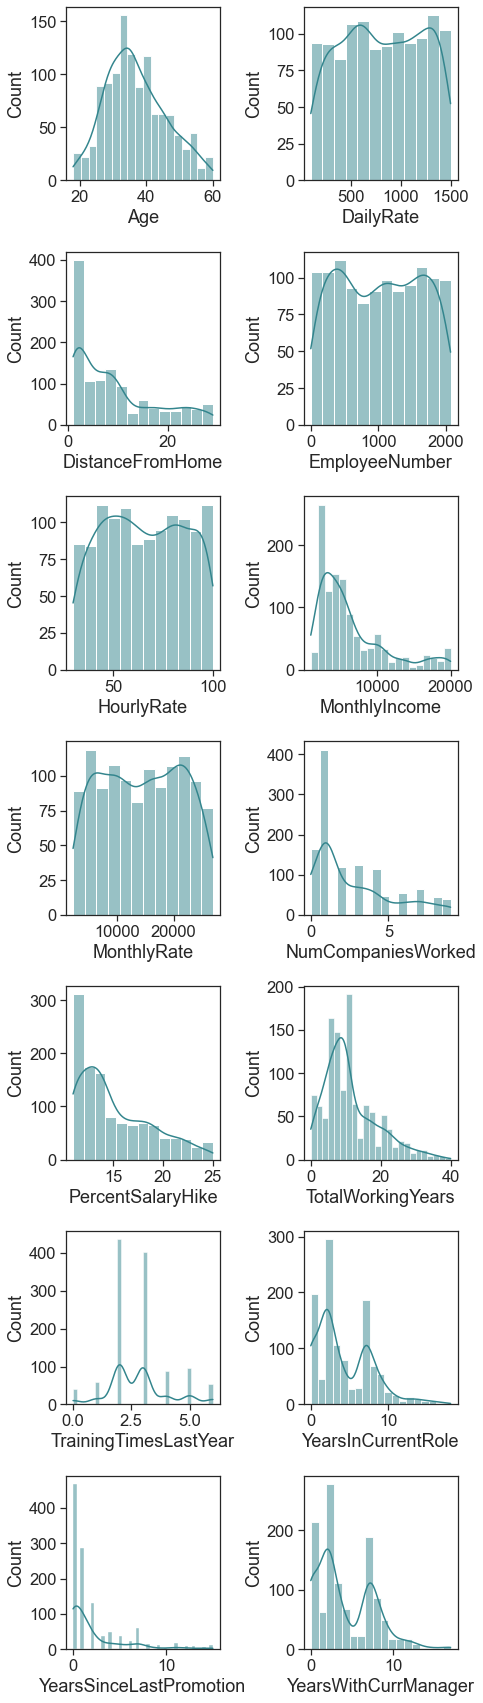

In [24]:
n_rows = len(num_ft)//2 + len(num_ft) % 2

fig = plt.figure(figsize=(7, 24))
sns.set_theme(font_scale=1.5, style="ticks")
sns.set_palette(sns.color_palette('crest', n_colors=1))

for (i, ft) in enumerate(num_ft):

    plt.subplot(n_rows, 2, i+1)
    ax = sns.histplot(x=data[ft], kde=True)

#fig.set_facecolor('w')
plt.tight_layout()
plt.show()

### 1.2.3. Employees' features influence on attrition <a class="anchor" id="section_1_2_3"></a>

Let's now look how our employee features relate to the attrition. We start by plotting the categorical features taking into account both possible attrition outcomes to see if we can visually find any patterns:

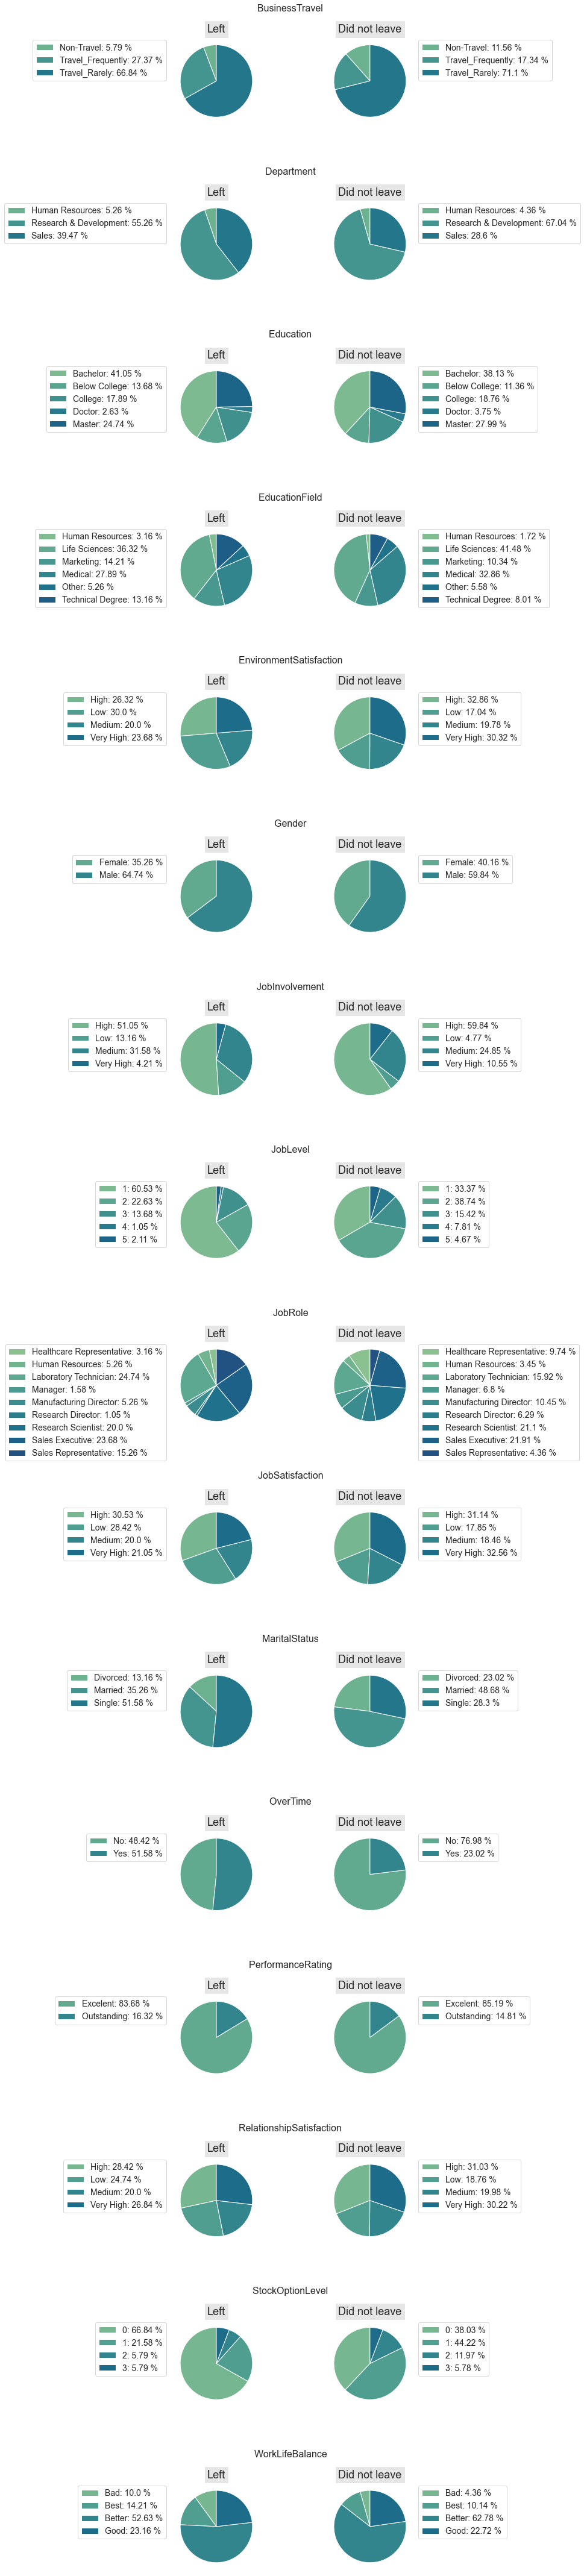

In [25]:
df_filtered = data_train_lb[cat_ft].nunique()

num_plots = len(df_filtered)
i=1

data_positive = data_train_lb[y_att!=0]
data_negative = data_train_lb[y_att==0]

fig, big_axes = plt.subplots(figsize=(15.0, 60.0) , nrows=num_plots, ncols=1) 

for row, big_ax in enumerate(big_axes, start=1):
    ft = df_filtered.index[row-1]
    big_ax.set_title(f'                    {ft}                      \n \n', fontsize=16)
    big_ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft = False, labelbottom = False )
    big_ax._frameon = False
    big_ax.grid(False)


for ft in df_filtered.index:

    ax = fig.add_subplot(num_plots,2,i)
    pos_ft_num = data_positive[ft].value_counts().sort_index()
    labels = list(pos_ft_num.index)

    colors = sns.color_palette(
        'crest', n_colors=len(pos_ft_num)+1)[0:len(pos_ft_num)]

    ax.pie(pos_ft_num, colors = colors, startangle=90)
    ax.set_title('Left', bbox={'facecolor':'0.9', 'pad':5})
    labels_box = [f'{label}: {round(counts*100/data_positive.shape[0],2)} %' for label, counts in zip(labels, pos_ft_num)]
    ax.legend(labels_box, loc='best', bbox_to_anchor=(-0.01, 1.0), fontsize=14)


    ax = fig.add_subplot(num_plots,2,i+1)
    neg_ft_num = data_negative[ft].value_counts().sort_index()
    labels = list(neg_ft_num.index)


    ax.pie(neg_ft_num, colors= colors, startangle=90)
    ax.grid(None)
    ax.set_title('Did not leave', bbox={'facecolor':'0.9', 'pad':5})
    labels_box = [f'{label}: {round(counts*100/data_negative.shape[0],2)} %' for label, counts in zip(labels, neg_ft_num)]
    ax.legend(labels_box, loc='best', bbox_to_anchor=(0.99, 1.0), fontsize=14)

    i=i+2

#fig.set_facecolor('w')
plt.tight_layout()
plt.show()

Looking at the previous plots, here are the main patterns we can see:
\
` `  
` `
<span style='color:teal'> **Positive attrition, employees who left**:  </span>
* Sales executives are the most prone to leave the company, followed by sales representativeas and other job roles such as lab technicians or employees from HR.
* Employees working over-time.
* Low job levels.
* Zero stock option.
* Single employees.
* Lower environment, job and relationship satisfaction.
* Lower job involvement.
* More fequent travel.
* Employees belonging to the sales department.
* Worse work-life balance.
\
` `  
` `

<span style='color:teal'> **Negative attrition, employees who did not leave**:  </span>
* Lead positions such as manager, manufacturing director and research director, as well as healthcare representatives are the more prone to not leave the company.
* Employees not working over-time.
* High job levels.
* Stock option levels above zero.
* Married employees, followed by divorced.
* Higher environment, job and relationship satisfaction.
* Higher job involvement.
* Non-travel or less travel involved.
* Employees belonging to the R&D deparment.
* Better work-life balance.

We now focus on the numerical features:

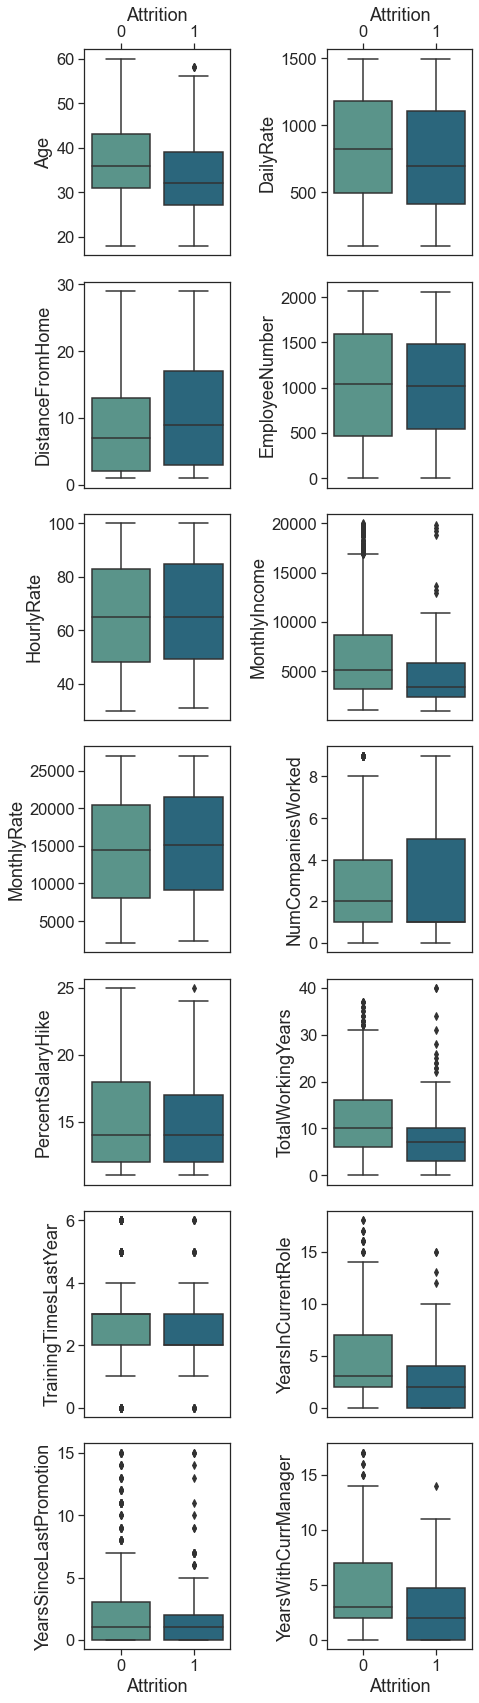

In [26]:
n_rows = len(num_ft)//2 + len(num_ft) % 2

fig = plt.figure(figsize=(7, 24))
sns.set_theme(font_scale=1.5, style="ticks")

for (i, ft) in enumerate(num_ft):

    plt.subplot(n_rows, 2, i+1)
    ax = sns.boxplot(y=data[ft], x=y_att,
                palette=sns.color_palette('crest', n_colors=2))
    if i < 2:
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
    elif i < 12:
        ax.xaxis.set_visible(False)
    #if ft in dict_fts:
    #    ft = dict_fts[ft]

    #plt.title(f'{ft}')

#fig.set_facecolor('w')
plt.tight_layout()
plt.show()

Looking at the previous plots, here are additional patterns we can see:
\
` `  
` `
<span style='color:teal'> **Positive attrition, employees who left**:  </span>
* Employees with less working years, especially less than 10 years.
* Monthly income below generally below 10k dollars.
* Younger employees with less than 40 years.
* Less than 5 years in the current position with the current manager, generally around 2.5 years.
\
` `  
` `

<span style='color:teal'> **Negative attrition, employees who did not leave**:  </span>
* Employees with more working years, generally more than 10 years.
* Monthly income below generally below 10k dollars.
* Younger employees with less than 40 years.
* Less than 5 years in the current position with the current manager, generally around 2.5 years.

It should be noted that visual identification of patterns is not the most efficient way to determine the influence of a feature on the a target such as attrition, as expected. Therefore, we use the pre-defined Mutual Information algorithm to quantify the grade of similarity between features, which is also able to measure non-linear relationships:

In [27]:
def make_plot_scores(dataset, feature, regression=False, cat_cols=cat_ft, threshold=0):

    # Create a copy of the train data removing all the rows containing missing values
    df_copy = dataset.dropna().copy()

    # We set the target
    y_copy = feature.copy()

    # Label object or category columns
    label_encoder = LabelEncoder()

    # We select categorical object and columns
    cat_cols = df_copy.select_dtypes(['object', 'category']).columns

    for col in cat_cols:
        df_copy[col] = label_encoder.fit_transform(df_copy[col])

    discrete_features = df_copy.columns.isin(cat_cols)

    # Obtain scores of mutual information

    if regression:
        scores = mutual_info_regression(
            df_copy, y_copy, discrete_features=discrete_features, random_state=1)
        pass
    else:
        scores = mutual_info_classif(
            df_copy, y_copy, discrete_features=discrete_features, random_state=1)

    list_features = []

    #for name_ft in df_copy.columns:
    #    list_features.append(dict_fts[name_ft])

    scores = pd.Series(scores, name="Scores", index=df_copy.columns)

    # Retain positive non-zero scores
    scores = scores[scores > threshold].sort_values(ascending=False)

    # Create bar plot
    width = np.arange(len(scores))
    ticks = list(scores.index)

    fig = plt.figure(figsize=(15, 30))

    sns.set_style('whitegrid')
    sns.barplot(x=scores, y=width, orient='h', color='lightseagreen')
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

    return scores.sort_values(ascending=False)

In [28]:
def make_plot_scores(dataset, feature, regression=False, cat_cols=cat_ft, threshold=0):

    # Create a copy of the train data removing all the rows containing missing values
    df_copy = dataset.dropna().copy()

    # We set the target
    y_copy = feature.copy()

    # Label object or category columns
    label_encoder = LabelEncoder()

    # We select categorical object and columns
    cat_cols = df_copy.select_dtypes(['object', 'category']).columns

    for col in cat_cols:
        df_copy[col] = label_encoder.fit_transform(df_copy[col])

    discrete_features = df_copy.columns.isin(cat_cols)

    # Obtain scores of mutual information

    if regression:
        scores = mutual_info_regression(
            df_copy, y_copy, discrete_features=discrete_features, random_state=1)
        pass
    else:
        scores = mutual_info_classif(
            df_copy, y_copy, discrete_features=discrete_features, random_state=1)

    list_features = []

    #for name_ft in df_copy.columns:
    #    list_features.append(dict_fts[name_ft])

    scores = pd.Series(scores, name="Scores", index=df_copy.columns)

    # Retain positive non-zero scores
    scores = scores[scores > threshold].sort_values(ascending=False)

    # Create bar plot
    width = np.arange(len(scores))
    ticks = list(scores.index)

    sns.set_theme(font_scale=1.75, style="ticks")
    height = 5
    fig = plt.figure(figsize=(height, height*1.5*golden_ratio))

    sns.barplot(x=scores, y=width, orient='h',
                palette=sns.color_palette('crest', n_colors=10))
    plt.yticks(width, ticks)
    #plt.title("Mutual Information Scores")

    return scores.sort_values(ascending=False)

We now plot the highest mutual information scores which represent the most related features to attrition:

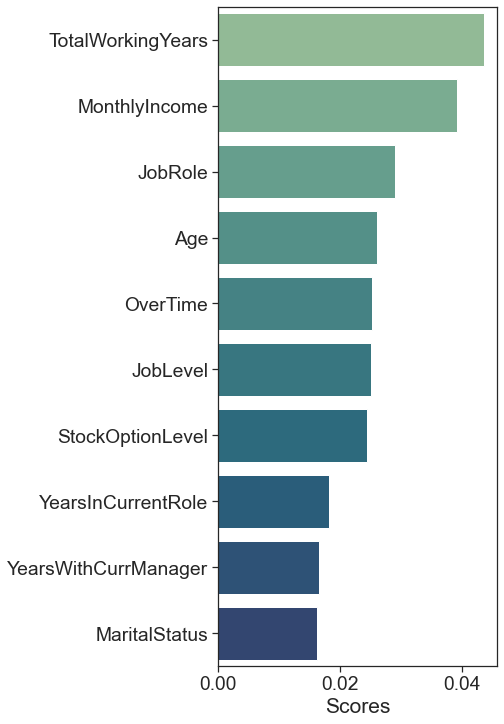

In [29]:
scores_att = make_plot_scores(dataset=data, feature=y_att, threshold=0.013)

As observed, the total number of working years and the monthly income are the two most influential features regarding an employee's attrition, followed by features such as the job role, age, whether the employee works overtime, the job level and the stock option level. This output coincides with the observations previously made when looking at the distribution plots. 

### 1.2.4. Employees' features influence on the total number of years at the company <a class="anchor" id="section_1_2_4"></a>

Let's now compute the mutual information scores with respect to the total number of years at the company:

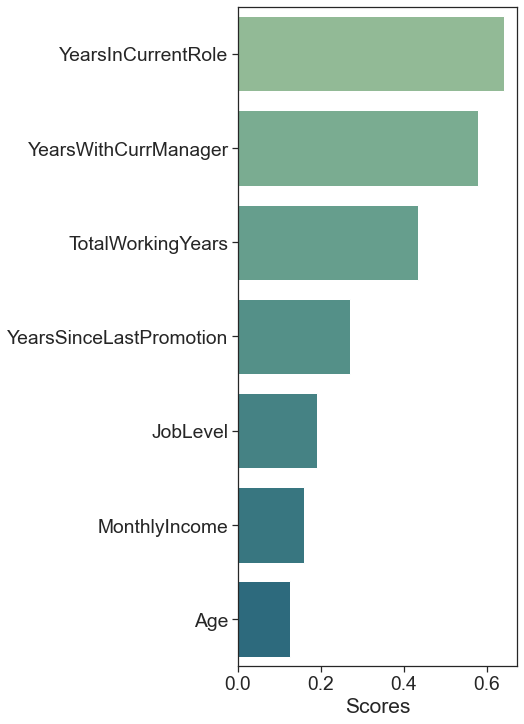

In [30]:
scores_years = make_plot_scores(dataset=data, feature=y_years, regression=True, threshold=0.1)

As observed, the most influential features is the number of years in the current role followed by the number of years with the current manager and the total number of working years. Other features such as the number of years since last promotion, the job level, the monthly income and the age are also seen to influence on this target, but with less impact than the other three.

Let's visually see these relations considering the continuous features:

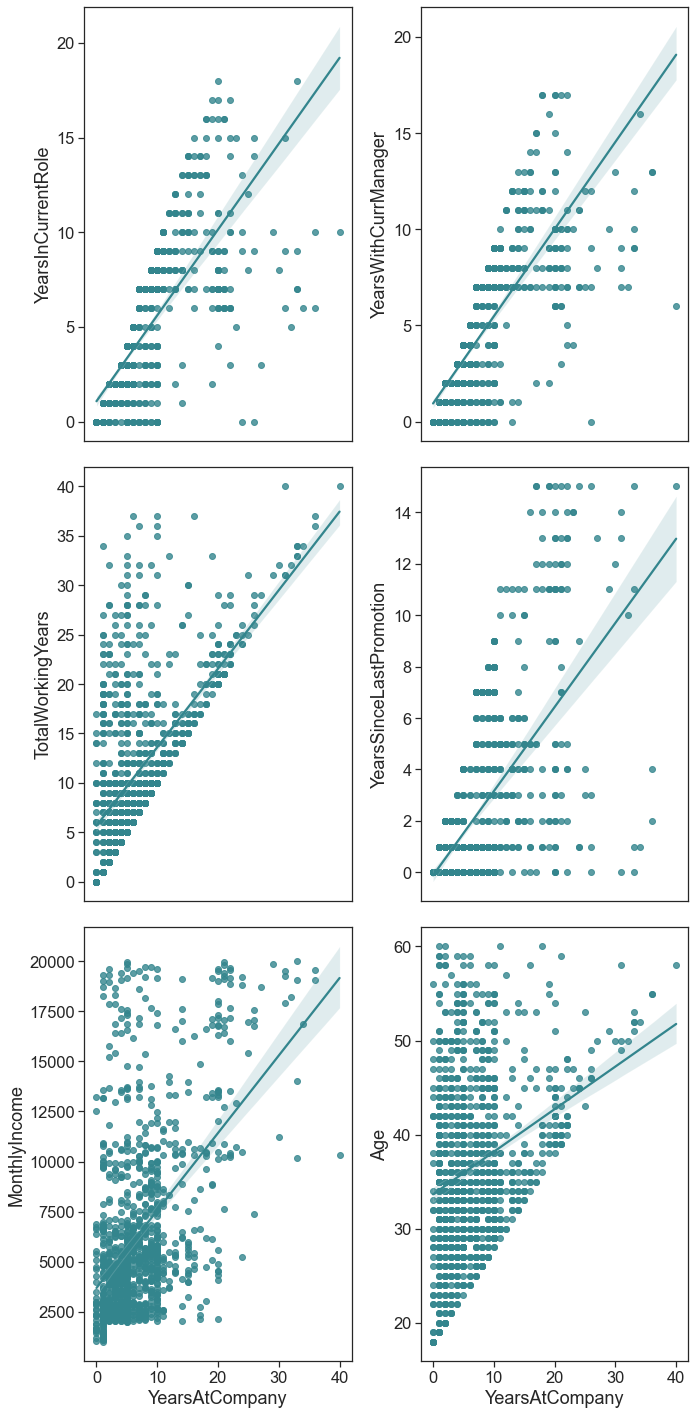

In [31]:
fts = list(scores_years.index)

fts, fts_cat = num_cat_cols(data[fts])

n_rows = len(fts)//2 + len(fts) % 2

fig = plt.figure(figsize=(10, 20))
sns.set_theme(font_scale=1.5, style="ticks")
sns.set_palette(sns.color_palette('crest', n_colors=1))

for (i, ft) in enumerate(fts):

    plt.subplot(n_rows, 2, i+1)
    
    ax = sns.regplot(y=data[ft], x=y_years)

    if i < 4:
        ax.xaxis.set_visible(False)

#fig.set_facecolor('w')
plt.tight_layout()
plt.show()

Overall, we can observe that the total number of years increase as the aforementioned features increase too. 

Let's now look at the categorical most influential features:

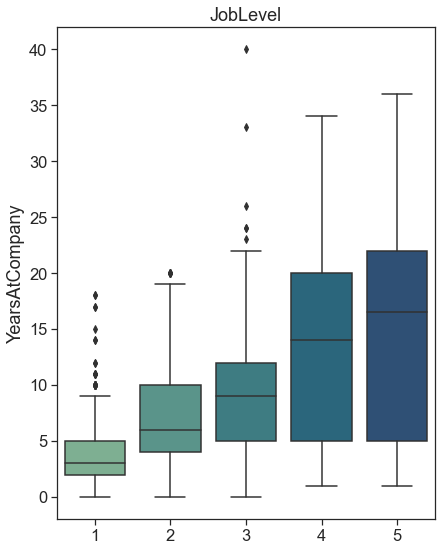

In [32]:
n_rows = len(fts_cat)//2 + len(fts_cat) % 2

fig = plt.figure(figsize=(12, 8))
sns.set_theme(font_scale=1.5, style="ticks")

for (i, ft) in enumerate(fts_cat):

    plt.subplot(n_rows, 2, i+1)
    ax = sns.boxplot(y=y_years, x=data[ft],
                palette=sns.color_palette('crest', n_colors=data[ft].nunique()))

    plt.title(ft)
    ax.set(xlabel=None)

    if i==1:
        ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
        ax.yaxis.set_visible(False)

#fig.set_facecolor('w')
plt.tight_layout()
plt.show()

As observed, higher number of years at the company lead to higher job levels, which is reasonable

### 1.2.5. Employees' features correlation <a class="anchor" id="section_1_2_5"></a>

Let's now check if there is any clear linear relationship between the existing features. To that end, we use the correlation matrix:

<AxesSubplot:>

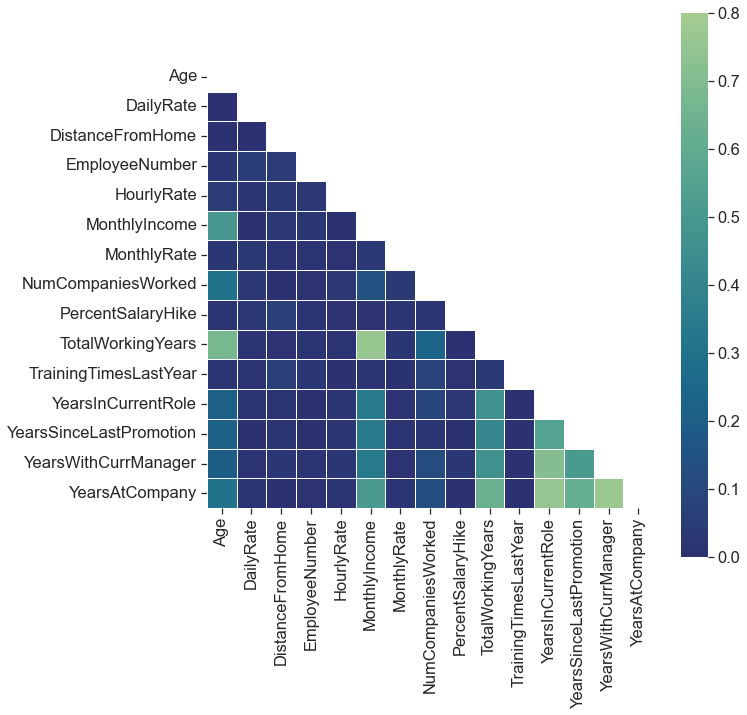

In [33]:
# We compute the correlation matrix

concatenated = pd.concat([data, y_years], axis=1)
corr_matrix = concatenated.corr()
matrix = np.triu(corr_matrix.abs())

# Plot the results in a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix.abs(), vmin= 0.0, vmax=0.8, linewidth=1,
            linecolor='w', square=True, cmap='crest_r', mask=matrix)

The figure above showcases the level of linear correlation among features. We can see that:
\
` `  
` `
<span style='color:teal'> **Very high correlated features:**  </span> (above 0.7):
* The <span style='color:cadetBlue'> **monthly income** </span> presents a ver high correlation to the number of  <span style='color:cadetBlue'> **total working years** </span>.
* The  <span style='color:cadetBlue'> **number of years at the company** </span> has a ver high correlation to the  <span style='color:cadetBlue'> **number of years in the current role** </span> and with the <span style='color:cadetBlue'> **years with the current manager** </span>, as previously seen.
\
` `  
` `

<span style='color:teal'> **High correlated features:**  </span> (between 0.5-0.7):
* The <span style='color:cadetBlue'> **total working years** </span> is highly correlated to the <span style='color:cadetBlue'> **age** </span> of the employee.
* The <span style='color:cadetBlue'> **years at the company** </span> is highly correlateed to the <span style='color:cadetBlue'> **monthly income** </span> , <span style='color:cadetBlue'> **total working years** </span> and the number of years since last promotion.
* The number of <span style='color:cadetBlue'> **years in the current role** </span> is highly correlated to number of <span style='color:cadetBlue'> **years since last promotion** </span> and the number of <span style='color:cadetBlue'> **years with the current manager** </span>.
* The number of <span style='color:cadetBlue'> **years with the current manager** </span> is highly correlated to the number of <span style='color:cadetBlue'> **years since last promotion** </span>.
\
` `  
` `

<span style='color:teal'> **Moderately correlated features:**  </span> (between 0.3-0.5):
* The <span style='color:cadetBlue'> **monthly income** </span> is moderately correlated to the <span style='color:cadetBlue'> **age** </span> of the employee.
* The <span style='color:cadetBlue'> **total working years** </span> is moderately correlated to the number of <span style='color:cadetBlue'> **years in the current role** </span>, <span style='color:cadetBlue'> **years with the current manager** </span>, and <span style='color:cadetBlue'> **years since last promotion** </span>.
* The <span style='color:cadetBlue'> **monthly income** </span>  is moderately correlated to the number of <span style='color:cadetBlue'> **years in the current role** </span>, <span style='color:cadetBlue'> **years with the current manager** </span>, and <span style='color:cadetBlue'> **years since last promotion** </span>.

In [34]:
#sns.pairplot(concatenated[fts])

Unfortunately, the correlation can only compute linear relationships between continous features. Let's look at the relationship between categorical features by using mutual information scores as previously done:

In [35]:
def label_encoder(dataset, cat_cols):
    # Assign labels to non-numerical features
    for col in cat_cols:
        dataset[col] = LabelEncoder().fit_transform(dataset[col])

    return dataset

In [36]:
# Assign labels to non-numerical features
num_ft, cat_ft = num_cat_cols(data)

concatenated = pd.concat([data[cat_ft], y_att_str], axis=1)

num_ft, cat_ft = num_cat_cols(concatenated)

train_cat = label_encoder(concatenated.copy(), cat_ft)

df_scores = pd.DataFrame(index=train_cat.columns, columns=train_cat.columns)
df_scores = df_scores.fillna(0)

# We create a matrix with all the mutual information scores
for ft in concatenated.columns:

    discrete_features = train_cat.loc[:, train_cat.columns != ft].columns.isin(cat_ft)
    scores = mutual_info_classif(
        train_cat.loc[:, train_cat.columns != ft], train_cat[ft], discrete_features=True, random_state=1)


    scores = pd.Series(scores, name="Scores",
                    index=train_cat.loc[:, train_cat.columns != ft].columns)
    scores[ft] = 1
    df_scores[ft] = scores

df_scores;


<AxesSubplot:>

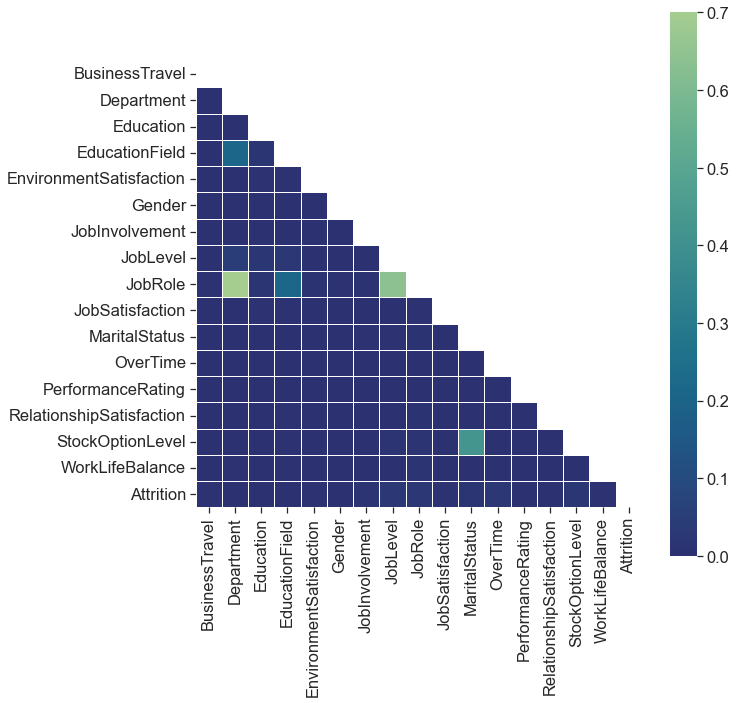

In [37]:
matrix = np.triu(df_scores)
plt.figure(figsize=(10, 10))
sns.heatmap(df_scores,  vmin= 0.0, vmax=0.7, linewidth=1, linecolor='w',
            square=True, cmap='crest_r', mask=matrix)


The figure above showcases the mutual information scores among categorical features. We can see that:
\
` `  
` `
* The <span style='color:cadetBlue'> **job role** </span> is highly related to the <span style='color:cadetBlue'> **department** </span> and <span style='color:cadetBlue'> **job level** </span>.
* The <span style='color:cadetBlue'> **stock option level** </span> is related to the <span style='color:cadetBlue'> **marital status** </span>.
* The <span style='color:cadetBlue'> **job role** </span> is moderately related to the <span style='color:cadetBlue'> **education field** </span>.
* The <span style='color:cadetBlue'> **education field** </span> is moderately related to the <span style='color:cadetBlue'> **department** </span>.

# 2. AI Models <a class="anchor" id="section_2"></a>

## 2.1. Data pre-processing <a class="anchor" id="section_2_1"></a>

In this section we are going to apply a series of transformations to our data prior to training the predicition models.

### 2.1.1. Encode categorical features  <a class="anchor" id="section_2_1_1"></a>

Prior to the application of any learning model, it is important to pre-process our data so that the input variables are in a compatible and efficient format. In the case of categorical variables, they should be encoded to numerical values. One way of encoding our categorical variables is to assign a numerical value as a label to each category included in a given feature. Another way would be to create multiple extra binary features for each subcategory. The latter can be done by means of OneHotEncoder algorithm:

In [38]:
# Apply one-hot encoder to each column with categorical data
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

num_ft, cat_ft = num_cat_cols(data)

concatenated = pd.concat([data[cat_ft], data_test[cat_ft]], axis=0)

encoded = pd.DataFrame(encoder.fit_transform(concatenated))
train_encoded = pd.DataFrame(encoder.transform(data[cat_ft]))
test_encoded = pd.DataFrame(encoder.transform(data_test[cat_ft]))


# Redefine index
train_encoded.index = data.index
test_encoded.index = data_test.index

# Set informative feature names
train_encoded.columns = encoder.get_feature_names_out(cat_ft)
test_encoded.columns = encoder.get_feature_names_out(cat_ft)

# Fetch numerical variable
num_train = data.drop(cat_ft, axis=1)
num_test = data_test.drop(cat_ft, axis=1)

# Add one-hot encoded categorical data to numerical features
train_encoded = pd.concat([num_train, train_encoded], axis=1)
test_encoded = pd.concat([num_test, test_encoded], axis=1)

Let's look now at the encoded data! The results show that for a given feature such as 'gender', the latter was replaced by two binary features corresponding to its subcategories of man and woman. In this way, male patients will only have a unit value in the column corresponding to this subcategory.

In [39]:
train_encoded[['Gender_Male','Gender_Female']].head()

,Gender_Male,Gender_Female
324,0.0,1.0
791,1.0,0.0
442,1.0,0.0
531,0.0,1.0
1419,1.0,0.0


### 2.1.2. Scale numerical features <a class="anchor" id="section_2_1_2"></a>

In the case of numerical variables, it is advantageous that all are represented in the same scale and distribution. It should be taken into account that our numerical data involves different orders of magnitudes depending on which feature we are looking at. This difference results in a wide scale range of weight values, which are devisive when training the model. The latter leads to poor performance and inapropiate learning, as the larger, and thus most-influential, weights will be affected by the input order of magnitude. In this way, instability and convergence problems arise. In order to address these issues, a standard normal distribution of input data is desired. For that end, we apply a standar scaler so that our input features have zero mean and unit variance:

In [40]:
scaler = StandardScaler()

train_scaled = pd.DataFrame(scaler.fit_transform(train_encoded[num_ft]))
test_scaled = pd.DataFrame(scaler.transform(test_encoded[num_ft]))

# Redefine index
train_scaled.index = data.index
test_scaled.index = data_test.index

train_scaled.columns = num_ft
test_scaled.columns = num_ft

# Fetch encoded features
cat_train = train_encoded.drop(num_ft, axis=1)
cat_test = test_encoded.drop(num_ft, axis=1)

# Add scaled numerical variables to encoded features
train_prep = pd.concat([cat_train, train_scaled], axis=1)
test_prep = pd.concat([cat_test, test_scaled], axis=1)

In [41]:
train_prep[num_ft].describe()

,Age,DailyRate,DistanceFromHome,EmployeeNumber,HourlyRate,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1.176000e+03,1.176000e+03,1.176000e+03,1.176000e+03,1.176000e+03,1.176000e+03,1.176000e+03,1.176000e+03,1.176000e+03,1.176000e+03,1.176000e+03,1.176000e+03,1.176000e+03,1.176000e+03
mean,8.156741e-17,-5.739929e-17,-7.552538e-18,4.380472e-17,-2.114711e-16,3.021015e-18,-1.027145e-16,2.114711e-17,2.567863e-17,8.156741e-17,8.760944e-17,-9.365147e-17,-3.021015e-18,9.176333e-17
std,1.000425e+00,1.000425e+00,1.000425e+00,1.000425e+00,1.000425e+00,1.000425e+00,1.000425e+00,1.000425e+00,1.000425e+00,1.000425e+00,1.000425e+00,1.000425e+00,1.000425e+00,1.000425e+00
min,-2.083263e+00,-1.767654e+00,-1.011334e+00,-1.691837e+00,-1.749192e+00,-1.169418e+00,-1.733595e+00,-1.070247e+00,-1.165839e+00,-1.461058e+00,-2.165508e+00,-1.163618e+00,-6.751327e-01,-1.155541e+00
25%,-7.546142e-01,-8.287339e-01,-8.886472e-01,-9.097309e-01,-8.649042e-01,-7.568802e-01,-8.676492e-01,-6.714477e-01,-8.910291e-01,-6.787523e-01,-6.150438e-01,-6.148254e-01,-6.751327e-01,-5.928426e-01
50%,-9.029009e-02,-1.120500e-02,-2.752115e-01,1.240457e-02,-2.974362e-02,-3.242453e-01,2.910499e-02,-2.726485e-01,-3.414093e-01,-1.572151e-01,1.601883e-01,-3.404289e-01,-3.640214e-01,-3.114936e-01
75%,6.847548e-01,8.843608e-01,5.835986e-01,8.900601e-01,8.545441e-01,3.728047e-01,8.740543e-01,5.249501e-01,7.578304e-01,4.947064e-01,1.601883e-01,7.571569e-01,-5.291008e-02,8.139025e-01
max,2.567007e+00,1.693219e+00,2.423906e+00,1.713351e+00,1.689705e+00,2.956501e+00,1.770000e+00,2.518946e+00,2.681500e+00,3.754314e+00,2.485885e+00,3.775518e+00,3.991537e+00,3.627393e+00


## 2.2. Classification models - Predicting employee attrition <a class="anchor" id="section_2_2"></a>

In order to evaluate the performance of the model. we will use **cross-validation**. In this way, the data is further splitted into a train and validation dataset. The former is employed for training the model and the latter is used for making predictions based on the output obtained from the training process. The assement of the model is done by computing the evaluation score of the algorithm in both the training and validation dataset. This whole process is repeatedly done in order to obtain a series of values out of which we can calculate the mean scores and their standard deviation. The repetition of this process ensures better representation of the data and does not only rely on an unique choice of training samples which could reflect the features' distribution properly. Hence, more reliability is achieved by looking at different subsets.

Furthermore, **learning curves** are computed also based on cross-validation. Learning curves are important in order to evaluate if overfitting or underfitting would take place. The latter implies poor performance on the training data and thus the model needs to more refined to achieve a satisfactory accuracy. The former however implies that the model performs quite well on the training data but is not good for generalising, that is, it is too sensible to any changes in the data and does not lead to good predictions when applied to new values. In this case, the learning curves illustrate the score variation as a function of number of the training samples for both the validation and training data. If both accuracies converge to a value together and the score value is high, the model will be suitable for future predictions. However, if the scores converge to a low value means that the model is underfitting. In the case of overfitting, no convergence is achieved and there a gap remains between the training and validation scores.

In the classification problem, when predicting attrition, the evaluation metric used in both cross-validation and learning curves is the weighted F1-score. This selection is done taking into account that F1 score is computed based on precision and recall metrics and also the fact that there is an imbalanced distribution of our target variables.

In [ ]:
def plot_val_curve(model_name, param_name, param_list, get_train_test_scores, X_train, y_train, my_model, scoring):

    train_scores, val_scores = get_train_test_scores(
        model_name, my_model, X_train, y_train, param_name, param_list, scoring)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    if scoring == 'neg_mean_absolute_error' or scoring == 'neg_root_mean_squared_error':
        train_scores_mean = -train_scores_mean
        train_scores_std = -train_scores_std
        val_scores_mean = -val_scores_mean
        val_scores_std = -val_scores_std

    pos_max = np.argmax(val_scores_mean)

    if scoring == 'neg_mean_absolute_error' or scoring == 'neg_root_mean_squared_error':
        print(
            f'The minimum MAE achieved in validation set is {round(np.min(-val_scores_mean),1)} years')
    else:
        print(
            f'The maximum mean score achieved in validation set is {round(np.max(val_scores_mean)*100,1)}% with {param_name}={param_list[pos_max]}')

    plt.figure()
    plt.title(f'{model_name} - Validation Curve')

    plt.xlabel(f'{param_name}')
    plt.ylabel('Score')
    #plt.ylim([0.5, 1.0])

    plt.grid(True)
    lw = 2

    plt.semilogx(param_list, train_scores_mean, 'o-',
                 label='Training score', color='lightgreen', lw=lw)
    plt.fill_between(param_list, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color='lightgreen', lw=lw)
    plt.semilogx(param_list, val_scores_mean, 'o-',
                 label='Cross-validation score', color='hotpink', lw=lw)
    plt.fill_between(param_list, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.2, color='hotpink', lw=lw)

    plt.legend(loc="best")

    return plt.gca()


In [ ]:
def get_train_test_scores(model_name, my_model, X_train, y_train, param_name, param_list, scoring):
    #param_name_transform = model_name.lower().replace(" ", "") + '__' + param_name

    print(f'{model_name}: {param_name} parameter variation.')
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

    if scoring == 'neg_mean_absolute_error' or scoring == 'neg_root_mean_squared_error':
        cv = 5

    train_scores, val_scores = validation_curve(my_model, X_train.values, y_train.values,
                                                param_name=param_name,
                                                param_range=param_list, cv=cv, scoring=scoring)

    return train_scores, val_scores


In [ ]:
def plot_learning_curve(model_name, model, X_train, y_train, scoring):

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    if scoring == 'neg_mean_absolute_error' or scoring == 'neg_root_mean_squared_error':
        cv = 5

    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=cv, scoring=scoring, train_sizes=np.linspace(0.1, 1.0, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(test_scores, axis=1)
    val_scores_std = np.std(test_scores, axis=1)

    if scoring == 'neg_mean_absolute_error' or scoring == 'neg_root_mean_squared_error':
        train_scores_mean = -train_scores_mean
        train_scores_std = -train_scores_std
        val_scores_mean = -val_scores_mean
        val_scores_std = -val_scores_std
    plt.title(f'{model_name} - Learning Curve')

    plt.xlabel('Training samples')
    plt.ylabel('Score')

    plt.grid(True)
    lw = 2

    plt.plot(train_sizes, train_scores_mean, 'o-',
             label='Training score', color='darkturquoise')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color='darkturquoise', lw=lw)
    plt.plot(train_sizes, val_scores_mean, 'o-',
             label='Validation score', color='darkorange')
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.2, color='darkorange', lw=lw)

    if scoring == 'neg_mean_absolute_error' or scoring == 'neg_root_mean_squared_error':
        print(
            f'The minimum MAE achieved in validation set is {round(np.min(-val_scores_mean),1)} years')
    else:
        print(
            f'The maximum mean score achieved in validation set is {round(np.max(val_scores_mean)*100,1)}%')

    plt.legend(loc="best")

    return plt.gca()


As aforementioned, a series of classification models are tested and their evaluation metrics are computed. In addition, an assessment of the most important model's parameters is done in order to improve the performance.

In order to undertand the evaluation metrics it is important to have the following concepts:

* **True Positives (TP):** for a given class, the portion of the model which was predicted as positive and whose target was actually positive, that is, portion of positive cases which were correctly predicted. For multiclass classification, a datapoint will be positive in one of the classes and negative in the rest. True positives will be those datapoints that are predicted positive in the actual class.
\
` `  
` `
* **False Positives (FP):** or a given class, the portion of the model which was predicted as positive and whose target was actually negative, that is, portion of negative cases which were incorrectly predicted. For multiclass classification, false positives will be predicted as positive in the wrong class and negative in the rest of classes (thus, in the actual class).
\
` `  
` `
* **False Negatives (FN):** or a given class, the portion of real positive cases which were wrongly classified as negative.
\
` `  
` `
* **True Negatives (TN):** or a given class, the portion of real negative cases which were correctly classified as negative.


Once the previous definitions are clear, we can define the evaluation metrics:

* **Accuracy:** ratio of correct predictions to the total number of samples. Despite the fact it is intuitive to think that higher accuracy undoubtely implies that our model presents a good performance, it does not necessarily mean that. The reason for this is that we can have a non-even distribution of the target classes such as in this case. Therefore, achieving a high accuracy would be mainly affected by how well the over-represented cases are predicted. If our model does not properly identify the under-represented cases this would not be clearly reflected by the accuracy.
\
` `  
` `
* **Recall:** for a given class, proportion of actual positives which were correctly identified. A model that produces no false negatives has a recall of 1.0.
\
` `  
` `
* **Precision:** for a given class, what proportion of positive identifications was actually correct? A model that produces no false positives has a precision of 1.0.
\
` `  
` `
* **F1-score:** harmonic mean of precision and recall. The highest possible value of an F-score is 1.0, indicating perfect precision and recall, and the lowest possible value is 0, if either the precision or the recall is zero.


### 2.2.1. K Neighbors Classifier <a class="anchor" id="section_2_2_1"></a>

K-neighbors model, as the name indicates, simply classifies our datapoints based on the number of nearest neighbors. More information about how this model works can be found [here](https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn). Consering this, we compute the cross-validation curves for different number of neighbors:

K Neighbors Classifier: n_neighbors parameter variation.
The maximum mean score achieved in validation set is 80.5% with n_neighbors=5


(0.6, 1.0)

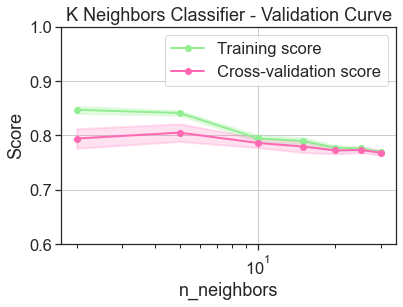

In [ ]:
neighbors_list = [2, 5, 10, 15, 20, 25, 30]

class_model = KNeighborsClassifier()

pt = plot_val_curve('K Neighbors Classifier', 'n_neighbors', neighbors_list,
                    get_train_test_scores, train_prep, y_att, class_model, 'f1_weighted')
pt.set_ylim([0.6, 1.0])

Apparently, k=5 neighbors provides the best results, although no big difference is observed.

Let's look at the learning curve:

The maximum mean score achieved in validation set is 80.5%


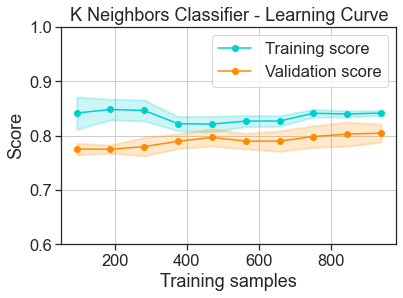

In [ ]:
class_model = KNeighborsClassifier(n_neighbors=5)

pt = plot_learning_curve('K Neighbors Classifier', class_model, train_prep.values, y_att.values, 'f1_weighted')
pt.set_ylim([0.6, 1.0]);

As observed, both the training and validation curves converge to a value around 0.8. Therefore, adding more datapoints would not lead to better results in this case. 

Let's take a closer look at how well the model performs in the training data:

In [ ]:
predict = KNeighborsClassifier(n_neighbors=5).fit(
    train_prep.values, y_att.values).predict(train_prep.values)
print(classification_report(y_att.values, predict))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       986
           1       0.88      0.27      0.42       190

    accuracy                           0.88      1176
   macro avg       0.88      0.63      0.67      1176
weighted avg       0.88      0.88      0.85      1176



Low recall value of 0.27 was achieved in the case of positive attrition, meaning that only 27% of employees who did leave the company were predicted to leave. The other metrics did provide good results around 0.9

We now apply the trained model to new test data:

In [ ]:
predict = KNeighborsClassifier(n_neighbors=5).fit(
    train_prep.values, y_att.values).predict(test_prep.values)
print(classification_report(y_att_test.values, predict))

              precision    recall  f1-score   support

           0       0.85      0.99      0.91       247
           1       0.57      0.09      0.15        47

    accuracy                           0.84       294
   macro avg       0.71      0.54      0.53       294
weighted avg       0.81      0.84      0.79       294



Values above 0.85 were obtained for both precision and recall in the case of negative attrition. Unfortunately, lower values were obtained when predicting positive attrition. In the latter case, the model was not able to idenfity a good proportion of the actual positives. Therefore, the performance of this model is poor.

### 2.2.2. Decision Tree Classifier <a class="anchor" id="section_2_2_2"></a>

Let's now test the decision tree classifier! This model resembles a flowchart-like tree structure with recursive partitioning. In this way, each datapoint goes through a series of branches where a series of decisions are made based on the value of its features until a category is assigned when it reaches the leafnode. More information about how this model works can be found [here](https://www.datacamp.com/community/tutorials/decision-tree-classification-python). In this case, we are going to study the effect of the maximum depth of tree on the F1-score results. Moreover, we set the class weight to be balanced so that the existing imbalance in the target categores is taken into account and fixed.

Decision Tree Classifier: max_depth parameter variation.
The maximum mean score achieved in validation set is 77.2% with max_depth=10


(0.6, 1.05)

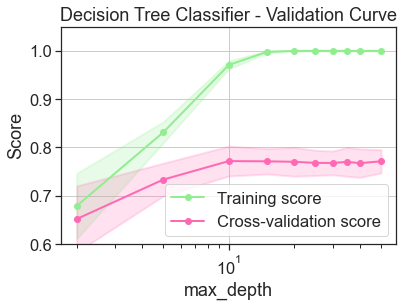

In [ ]:
depth_list = [2, 5, 10, 15, 20, 25, 30, 35, 40, 50]

class_model = DecisionTreeClassifier(class_weight='balanced')

pt = plot_val_curve('Decision Tree Classifier', 'max_depth',
                    depth_list, get_train_test_scores, train_prep, y_att, class_model, 'f1_weighted')
pt.set_ylim([0.6, 1.05])


We select a maximum depth of 10 since no big difference is oberved for larger values.

The maximum mean score achieved in validation set is 77.8%


(0.4, 1.1)

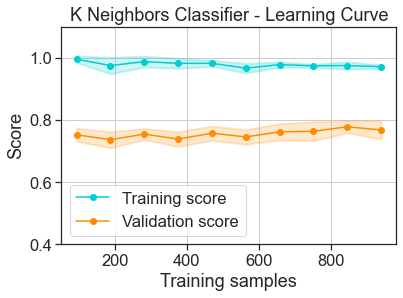

In [ ]:
class_model = DecisionTreeClassifier(class_weight='balanced', max_depth=10)

pt = plot_learning_curve('K Neighbors Classifier', class_model, train_prep, y_att, 'f1_weighted')
pt.set_ylim([0.4, 1.1])

In this case, the model does not seem to gain noticeable learning as the number of samples increase. Actually, the maximum score is achived in the training set from the very beggining, whereas the validation score does not seem to improve. This means our model is prone to over-fitting. This behaviour however, is characteristic of the current model we are employing. Decision trees are characterised by having extremely low bias (thus, high variance and over-fitting). Furthemore, considering the architecture of this model, the validation data will simply pass through an already determined set of tree branches where simple decisions are taken.

Let's look at the precision and recall values:

In [ ]:
predict = DecisionTreeClassifier(class_weight='balanced', max_depth=10).fit(
    train_prep.values, y_att.values).predict(train_prep.values)
print(classification_report(y_att, predict))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       986
           1       0.85      1.00      0.92       190

    accuracy                           0.97      1176
   macro avg       0.93      0.98      0.95      1176
weighted avg       0.98      0.97      0.97      1176



Overall, high values were obtained.

We now apply the trained model to new test data:

In [ ]:
predict = DecisionTreeClassifier(class_weight='balanced', max_depth=10).fit(
    train_prep.values, y_att.values).predict(test_prep.values)
print(classification_report(y_att_test, predict))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87       247
           1       0.40      0.57      0.47        47

    accuracy                           0.79       294
   macro avg       0.65      0.70      0.67       294
weighted avg       0.83      0.79      0.81       294



Better results are obtained compared to the previous model. Both precision and recall have values above 0.8 in the case of negative attrition. However, these values again are lower in the case of positive attrition. In the latter, a precision of 0.4 is achieved, which means than 40% of the cases predicted positive were actually so. Thus, 40% of the employees who were predicted to leave, did actually leave. Moreover, 57% of the employees who did actually leave were identified with positive attrition.

If we compare the evaluation metrics for both the test and training sets, we can observe a noticeable difference in the case of positive attrition. Therefore, the model overfits since good predictions were obtained with the training data whereas not satisfactory identification of positive attrition was obtained when applied to new data.

### 2.2.3. Random Forest Classifier <a class="anchor" id="section_2_2_3"></a>

The next model is the random forest classifier. This model consist of a series of decision trees applied to various sub-samples of the training set. For classification tasks, the output of the random forest is the class selected by most trees. More information about how this model works can be found [here](https://www.datacamp.com/community/tutorials/random-forests-classifier-python). In this case, we are going to study the effect of number of estimators or trees and the maximum depth on the F1-score results. In the same way as before, we set the class weight to be balanced so that the existing imbalance in the target categores is taken into account and fixed.

Random Forest: n_estimators parameter variation.
The maximum mean score achieved in validation set is 80.5% with n_estimators=15


(0.6, 1.01)

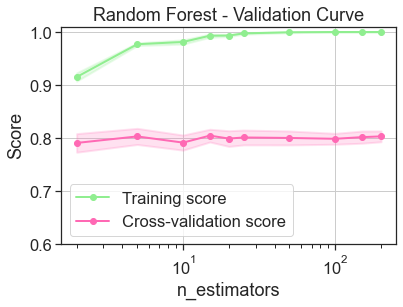

In [ ]:
n_estimators = [2, 5, 10, 15, 20, 25, 50, 100, 150, 200]
class_model = RandomForestClassifier(class_weight='balanced')
pt = plot_val_curve('Random Forest', 'n_estimators', n_estimators,
                    get_train_test_scores, train_prep, y_att, class_model, 'f1_weighted')
pt.set_ylim([0.6, 1.01])


We select 15 estimators, although no big difference is observed.

Random Forest: max_depth parameter variation.
The maximum mean score achieved in validation set is 81.2% with max_depth=10


(0.6, 1.01)

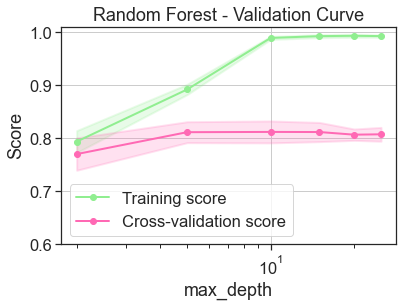

In [ ]:
depth_list = [2, 5, 10, 15, 20, 25]
class_model = RandomForestClassifier(n_estimators=15, class_weight='balanced')
pt = plot_val_curve('Random Forest', 'max_depth', depth_list,
                    get_train_test_scores, train_prep, y_att, class_model, 'f1_weighted')
pt.set_ylim([0.6, 1.01])


In the case of the maximum tree depth, no substantial improvement is either seen in the validation set, whereas the training set keeps getting better results, as was to be expected.

The maximum mean score achieved in validation set is 82.4%


(0.4, 1.1)

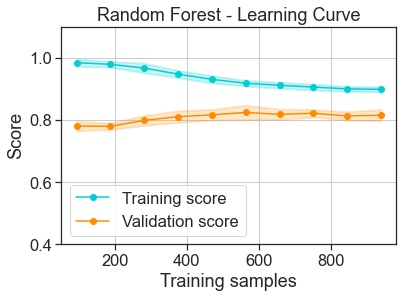

In [ ]:
class_model = RandomForestClassifier(n_estimators=15, max_depth=5, class_weight='balanced', random_state=6)

pt = plot_learning_curve('Random Forest', class_model, train_prep, y_att, 'f1_weighted')
pt.set_ylim([0.4, 1.1])

As observed from the previous plot, both curves tend to converge but a small gap remains, thus more training samples would be needed to achieve converge. 

Let's look at the precision and recall values obtained when the model is applied to both training and test data:

In [ ]:
predict = RandomForestClassifier(n_estimators=15, max_depth=5, class_weight='balanced', random_state=6).fit(
    train_prep.values, y_att.values).predict(train_prep.values)
print(classification_report(y_att, predict))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       986
           1       0.57      0.75      0.65       190

    accuracy                           0.87      1176
   macro avg       0.76      0.82      0.78      1176
weighted avg       0.89      0.87      0.88      1176



In [ ]:
predict = RandomForestClassifier(n_estimators=15, max_depth=5, class_weight='balanced', random_state=6).fit(
    train_prep.values, y_att.values).predict(test_prep.values)
print(classification_report(y_att_test, predict))


              precision    recall  f1-score   support

           0       0.92      0.86      0.89       247
           1       0.45      0.62      0.52        47

    accuracy                           0.82       294
   macro avg       0.69      0.74      0.71       294
weighted avg       0.85      0.82      0.83       294



Once again, computed precision and recall are above 0.8 in the case of negative attrition. However, it seems that the model still struggles to achieve high precision and recall when predicting positive attrition. 

### 2.2.4. Logistic Regression <a class="anchor" id="section_2_2_4"></a>

We now continue with testing the logistic regression technique, which is based on a sigmoid function for classification. In this case, we look at the influence of C parameter in the accuracy of results, which represents the inverse of regularization strength. Keep in mind that regularization is an important step in order to minimize the risk of over-fitting. More information about how this model works can be found [here](https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python).

Logistic Regression: C parameter variation.
The maximum mean score achieved in validation set is 80.0% with C=0.5


(0.6, 1.0)

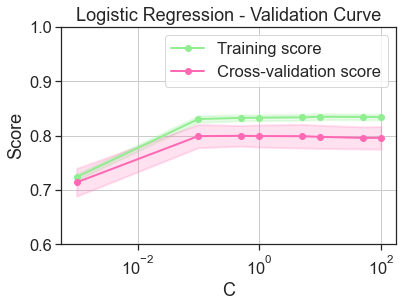

In [ ]:
C_list = [0.001, 0.1, 0.5, 1, 5, 10, 50, 100]

class_model = LogisticRegression(
    solver='liblinear', max_iter=5000, multi_class='auto', class_weight='balanced')
pt = plot_val_curve('Logistic Regression', 'C', C_list,
                    get_train_test_scores, train_prep, y_att, class_model, 'f1_weighted')
pt.set_ylim([0.6, 1.0])


F1-scores around 0.8 are achieved in both the validation and training set. The regularization parameter seems to provide the best scores in the validation data when C=0.1. Let's now look at the learning curves:

The maximum mean score achieved in validation set is 79.9%


(0.4, 1.1)

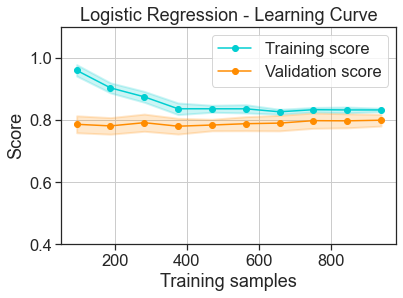

In [ ]:
class_model = LogisticRegression(solver='liblinear', C=0.5, class_weight='balanced')

pt = plot_learning_curve('Logistic Regression', class_model, train_prep, y_att, 'f1_weighted')
pt.set_ylim([0.4, 1.1])

As observed in the learning curves above, both training and validation curves quickly converge to a stable value above 0.8. This means that our model presents good performance in terms of over-fitting and under-fitting.

Let's look at the precision and recall values obtained when the model is applied to both training and test data:

In [ ]:
predict = LogisticRegression(C=0.5, class_weight='balanced', multi_class='auto').fit(
    train_prep.values, y_att.values).predict(train_prep.values)
print(classification_report(y_att, predict))

              precision    recall  f1-score   support

           0       0.96      0.80      0.87       986
           1       0.44      0.83      0.58       190

    accuracy                           0.81      1176
   macro avg       0.70      0.81      0.73      1176
weighted avg       0.88      0.81      0.83      1176



In [ ]:
predict = LogisticRegression(solver='liblinear', C=0.1, class_weight='balanced', multi_class='auto').fit(
    train_prep.values, y_att.values).predict(test_prep.values)
print(classification_report(y_att_test, predict))

              precision    recall  f1-score   support

           0       0.96      0.77      0.86       247
           1       0.41      0.85      0.56        47

    accuracy                           0.78       294
   macro avg       0.69      0.81      0.71       294
weighted avg       0.88      0.78      0.81       294



In this case, high recall is obtained for positive attrition as 83% and 85% of the employees who did actually leave were identified for both sets. In the case of the recall, values around 41-44% of the employees predicted to leave did actually leave. 

Very similar results were obtained with both the training and test sets, therefore the model does not overfits.

### 2.2.5. Neural Networks <a class="anchor" id="section_2_2_5"></a>

In this section, a neural network for predicting employee attrition is created. In this case, we are going to use two hidden layers, the first one with 32 activation units, the second one with 8 activation layers, and one final two-dimensional output layer with sigmoid function since this is a binary problem. Furthermore, ReLU activation function is selected to include non-linearity. A dropout layer was included to reduce overfitting.

Let's define the metrics we want to check:

In [43]:
metrics_list = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc')];

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-02-28 13:12:39.315009: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-28 13:12:39.315859: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Additionally, early stopping callback is added to the model in order to stop the training if the validation loss starts to diverge with further iterations. In this case, a minimum of 50 epochs is set before the model stops and the best weights achieved are restored.

In [44]:
es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=50, restore_best_weights=True)

In [46]:
model = Sequential()
model.add(Dense(32, input_dim=train_prep.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=metrics_list)

Let's split the data into training and validation sets:

In [47]:
X_train_nn, X_valid_nn, y_train_nn, y_valid_nn = train_test_split(
    train_prep, y_att, stratify=y_att, train_size=0.9, test_size=0.1, random_state=123)
weights = class_weight.compute_sample_weight('balanced', y_train_nn)

We still need to take into account the class imbalance, therefore we need to compute the weights that will be used by the model. 

Finally, we set the number of epochs and we run the model. Epochs value represents the number of times the model will run through the whole dataset if no early stopping occurs. In addition, we set the value of the batch size, which represents the number of samples the model need to run through in order to update the internal parameters.

In [48]:
batch_size = 32

history = model.fit(X_train_nn,
                    y_train_nn,
                    epochs=300,
                    batch_size=batch_size,
                    validation_data=(X_valid_nn, y_valid_nn),
                    #shuffle= True,
                    callbacks=es,
                    sample_weight=weights)

2022-02-28 13:12:57.581332: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-28 13:12:57.584764: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/300


2022-02-28 13:12:58.365074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - ETA: 0s - loss: 0.7903 - accuracy: 0.2637 - precision: 0.1615 - recall: 0.8480 - auc: 0.4667

2022-02-28 13:13:00.027943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 3s 42ms/step - loss: 0.7903 - accuracy: 0.2637 - precision: 0.1615 - recall: 0.8480 - auc: 0.4667 - val_loss: 0.6924 - val_accuracy: 0.6186 - val_precision: 0.2500 - val_recall: 0.6842 - val_auc: 0.6834
Epoch 2/300
34/34 [==============================] - 1s 17ms/step - loss: 0.7082 - accuracy: 0.3582 - precision: 0.1825 - recall: 0.8538 - auc: 0.5756 - val_loss: 0.6707 - val_accuracy: 0.7458 - val_precision: 0.3590 - val_recall: 0.7368 - val_auc: 0.8017
Epoch 3/300
34/34 [==============================] - 1s 19ms/step - loss: 0.6649 - accuracy: 0.4225 - precision: 0.2011 - recall: 0.8655 - auc: 0.6687 - val_loss: 0.6529 - val_accuracy: 0.7712 - val_precision: 0.3750 - val_recall: 0.6316 - val_auc: 0.8288
Epoch 4/300
34/34 [==============================] - 1s 18ms/step - loss: 0.6524 - accuracy: 0.4896 - precision: 0.2094 - recall: 0.7778 - auc: 0.6818 - val_loss: 0.6379 - val_accuracy: 0.8051 - val_precision: 0.4286 - val_recall: 0.6316 - val_

In the figure below, we can see how the loss progressively decreases with the number of epochs until both curves converge and then the validation loss starts to increase again while the training loss keeps decreasing. This behaviour is normal when training our neural network. If the model is properly learning, both the validation and training losses decrease during this proccess until a point where the model starts to overfit, thus the validation loss starts to increase. Fortunately, we stopped the model training before divergence takes place and retrieve the best computed weights. 

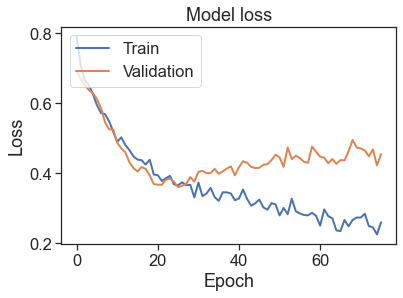

In [49]:
plt.plot(history.history['loss'], linewidth=2.0)
plt.plot(history.history['val_loss'], linewidth=2.0)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Let's now check our evaluation metrics:

In [52]:
y_pred = model.predict(train_prep)
predictions = [int(round(val[0])) for val in y_pred]
print(classification_report(y_att,predictions))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       986
           1       0.66      0.85      0.74       190

    accuracy                           0.90      1176
   macro avg       0.81      0.88      0.84      1176
weighted avg       0.92      0.90      0.91      1176



Let's now check how it performs when applied to unseen data:

In [51]:
y_pred = model.predict(test_prep)
predictions = [int(round(val[0])) for val in y_pred]
#y_test_class = np.argmax(y_pred, axis=1)
print(classification_report(y_att_test,predictions))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       247
           1       0.53      0.70      0.61        47

    accuracy                           0.85       294
   macro avg       0.74      0.79      0.76       294
weighted avg       0.87      0.85      0.86       294



2022-02-28 14:17:27.594768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


As observed from the previous results, neural networks provided evaluation metrics above 0.5. When predicting positive attrition, better recall was obtained with logistic regression, achieving values of 0.85. Nonetheless, the latter provided worse precision with values below 0.5. Therefore, neural networks provide overall better results. However, if our main objective is to avoid false negatives (employees who were predicted to stay but they ended up leaving) then we should keep in mind that logistic regression provides better results in this case.

## 2.3. Regression models - Predicting number of years in the company <a class="anchor" id="section_2_3"></a>

Let's now focus on predicting the number of years in the company by means of regression approaches. In this case, the evaluation metric used in both cross-validation and learning curves is the mean absolute error (MAE). 

### 2.3.1. Ridge regression <a class="anchor" id="section_2_3_1"></a>

Ridge model is a regression model based on the linear least squares function with a regularization term which allows better control of model performance and variace in the results. The latter follows the L2 regularization which is based on the square of the magnitude of the coefficients. The regularization parameter to consider in this case is the regularization strength alpha, which is a positive float. In this way, increasing alpha implies higher regularization applied to the model.

Random Forest Classifier: alpha parameter variation.
The minimum MAE achieved in validation set is -1.9 years


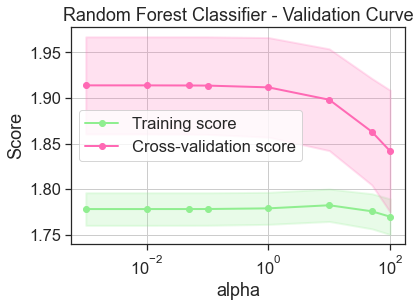

In [ ]:
# Regularization strength 
alpha_list = [0.001, 0.01, 0.05, 0.1, 1, 10, 50, 100]

reg_model = Ridge(random_state=1)
pt = plot_val_curve('Random Forest Classifier', 'alpha', alpha_list, get_train_test_scores, train_prep, y_years, reg_model, 'neg_mean_absolute_error');

We keep the default alpha value of 1. Let's now at the learning curves:

The minimum MAE achieved in validation set is -2.9 years


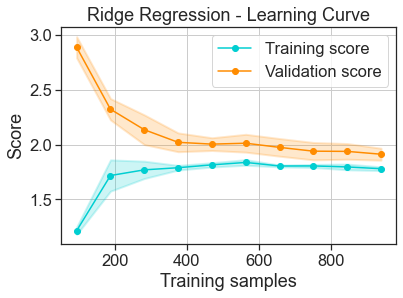

In [ ]:
class_model = Ridge(random_state=1)

pt = plot_learning_curve('Ridge Regression', reg_model, train_prep, y_years, 'neg_mean_absolute_error')

As observed, both curves converge to a MAE value below 2 years. Therefore, adding more datapoints is needless for achieving better performance

We now apply this model to unseen data and compute both MAE and MSE metrics:

In [ ]:
predict= Ridge(random_state=1).fit(train_prep.values,y_years.values).predict(test_prep.values)
print(mean_absolute_error(y_years_test, predict))
print(mean_squared_error(y_years_test, predict))

2.0274698868079337
10.236899763051172


As observed, both training and test sets have similar MAE values, meaning the model performs similarly in both sets and therefore no overfitting is taking place. 

### 2.3.2. Neural networks <a class="anchor" id="section_2_3_2"></a>

Let's now use a neural network model with one hidden layer consisting of 16 activation units and a final layer with linear activation since this is a regression problem

In [ ]:
model = Sequential()
model.add(Dense(16, input_dim=train_prep.shape[1], kernel_initializer='normal', activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mse','mae'])

Similarly as before, we split the data:

In [ ]:
X_train_nn, X_valid_nn, y_train_nn, y_valid_nn = train_test_split(
    train_prep, y_years, train_size=0.9, test_size=0.1, random_state=12)

Now we fit our model:

In [ ]:
batch_size = 32

history = model.fit(X_train_nn,
                    y_train_nn,
                    epochs=300,
                    batch_size=batch_size,
                    validation_data=(X_valid_nn, y_valid_nn), callbacks=es)
#shuffle= True,)


Epoch 1/300
11/34 [========>.....................] - ETA: 0s - loss: 6.9785 - mse: 86.2647 - mae: 6.9785

2022-02-25 17:17:11.694271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 1s 10ms/step - loss: 6.6073 - mse: 82.4478 - mae: 6.6073 - val_loss: 5.6576 - val_mse: 53.1072 - val_mae: 5.6576
Epoch 2/300
22/34 [==================>...........] - ETA: 0s - loss: 5.7235 - mse: 69.3168 - mae: 5.7235

2022-02-25 17:17:12.065366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 0s 6ms/step - loss: 5.4539 - mse: 64.4995 - mae: 5.4539 - val_loss: 4.5789 - val_mse: 37.1872 - val_mae: 4.5789
Epoch 3/300
34/34 [==============================] - 0s 6ms/step - loss: 4.4789 - mse: 47.4406 - mae: 4.4789 - val_loss: 3.6710 - val_mse: 24.7697 - val_mae: 3.6710
Epoch 4/300
34/34 [==============================] - 0s 6ms/step - loss: 3.6910 - mse: 33.8693 - mae: 3.6910 - val_loss: 2.9816 - val_mse: 16.7308 - val_mae: 2.9816
Epoch 5/300
34/34 [==============================] - 0s 6ms/step - loss: 3.1518 - mse: 24.8359 - mae: 3.1518 - val_loss: 2.5436 - val_mse: 12.7016 - val_mae: 2.5436
Epoch 6/300
34/34 [==============================] - 0s 6ms/step - loss: 2.7526 - mse: 19.6022 - mae: 2.7526 - val_loss: 2.2533 - val_mse: 10.4704 - val_mae: 2.2533
Epoch 7/300
34/34 [==============================] - 0s 6ms/step - loss: 2.3895 - mse: 15.7096 - mae: 2.3895 - val_loss: 1.9865 - val_mse: 8.4139 - val_mae: 1.9865
Epoch 8/300
34/34 [====

If we look at the computed loss we can see it rapidly decreases until convergence is achieved:

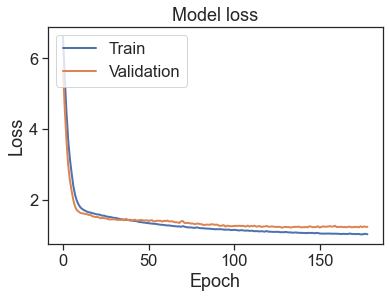

In [ ]:
plt.plot(history.history['loss'], linewidth=2.0)
plt.plot(history.history['val_loss'], linewidth=2.0)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Let's now compute MAE and MSE metrics when the model is applied to unseen data:

In [ ]:
predict = model.predict(test_prep.values)
print(f'MAE: {mean_absolute_error(y_years_test, predict)} years')
print(f'MSE: {mean_squared_error(y_years_test, predict)}');

MAE: 1.4681969762456661 years
MSE: 6.324241531433531


2022-02-25 17:17:48.710422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


As obseved, neural networks provide better results compared to Ridge regression. The former led to MAE of 1.4 years whereas the latter resulted in MAE of 2 years. In the case of MSE, better outcomes were also obtained.

# 3. Conclusion

Prediction models have been developed to address the following questions:

* <span style='color:teal'> **Will an employee leave?**  </span>
* <span style='color:teal'>**How many years will an employee stay?**</span>

**Neural networks** have resulted to offer the best results when predicting employee attrition and the number of years at the company. Nonetheless, if our priority is to avoid the cases where an employee is mistakenly predicted to stay, then logistic model should be used.

<img src="./images/img_3.png" width="500" height="250" align="center"/>

Furthermore, throughout data exploration and analysis we aimed to answer these points: 

* <span style='color:teal'> **Why would an employee leave?**  </span>
* <span style='color:teal'> **What are the risk factors to keep track of?**  </span>


Outcomes from this study show that the main factors that influence employees' staying in the company are <span style='color:cadetBlue'> **the number of total working years, the number of years in the current role and the number of years with the current manager, the monthly income, the job role and job level, the age, the stock option level and working overtime** </span>.

However, some of these attributes are not manageable. For example, a company cannot change employees' age or total number of working years. Therefore, we should focus on these factors on which companies have control. Based on this, the following proposals may be adopted for increasing the changes of employees' remaining in the company:

* **Monthly income**: increasing monthly income.
* **Job level**: upgrading the job level.
* **Overtime**: avoiding working overtime.
* **Stock option level**: allowing higher stock option levels.
* **Job role**: certain positions tend to have more turnover, such as those related to sales. Therefore employees working in roles that have been seen to be more steady will remain longer. Nonetheless, hiring for certain job roles depends on the company's needs.

<img src="./images/img_4.jpg" width="550" height="300" align="center"/>